## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
# dropout: 0.25, 0.1
# regularizers: L1, L2
# batch-normalization: True, False

In [2]:
import os
import keras
import itertools
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt

color_bar = ["r", "g", "b", "y", "m", "k", "c", "orange"]

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
reg_ratio = [1e-4, 1e-8]
drop_ratio = [0.1, 0.25]
batch_n = [True, False]

## L1

In [7]:
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], drop_ratio=0.2, l_ratio=0.0001, bn=True):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l_ratio))(input_layer)
            x = Dropout(drop_ratio)(x)
            if bn:
                x = BatchNormalization()(x)
            else:
                pass
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l_ratio))(x)
            x = Dropout(drop_ratio)(x)
            if bn:
                x = BatchNormalization()(x)
            else:
                pass
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
results_l1 = {}

for i in drop_ratio:
    for j in reg_ratio:
        for k in batch_n:
            model = build_mlp_l1(input_shape=x_train.shape[1:], drop_ratio=i, l_ratio=j, bn=k)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)
            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]
            exp_name_tag = f'drp_{str(i)}_reg_{str(j)}_bn_{str(k)}'
            results_l1[exp_name_tag] = {'train-loss': train_loss,
                                        'valid-loss': valid_loss,
                                        'train-acc': train_acc,
                                        'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024

Epoch 44/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.9756 - accuracy: 0.5526 - val_loss: 3.2494 - val_accuracy: 0.4565
Epoch 45/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.9378 - accuracy: 0.5523 - val_loss: 3.1074 - val_accuracy: 0.4888
Epoch 46/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.8970 - accuracy: 0.5537 - val_loss: 3.0942 - val_accuracy: 0.4806
Epoch 47/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.8755 - accuracy: 0.5494 - val_loss: 3.0589 - val_accuracy: 0.4835
Epoch 48/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.8318 - accuracy: 0.5504 - val_loss: 3.0736 - val_accuracy: 0.4637
Epoch 49/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.7910 - accuracy: 0.5539 - val_loss: 3.0070 - val_accuracy: 0.4743
Epoch 50/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.7558 - accuracy: 0.5528 - val_

50000/50000 [==============================] - 2s 36us/step - loss: 3.1924 - accuracy: 0.5572 - val_loss: 3.2478 - val_accuracy: 0.5264
Epoch 40/50
50000/50000 [==============================] - 2s 36us/step - loss: 3.1496 - accuracy: 0.5572 - val_loss: 3.2349 - val_accuracy: 0.5218
Epoch 41/50
50000/50000 [==============================] - 2s 38us/step - loss: 3.1033 - accuracy: 0.5600 - val_loss: 3.1592 - val_accuracy: 0.5288
Epoch 42/50
50000/50000 [==============================] - 2s 38us/step - loss: 3.0623 - accuracy: 0.5587 - val_loss: 3.1264 - val_accuracy: 0.5251
Epoch 43/50
50000/50000 [==============================] - 2s 39us/step - loss: 3.0142 - accuracy: 0.5644 - val_loss: 3.0785 - val_accuracy: 0.5349
Epoch 44/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.9729 - accuracy: 0.5653 - val_loss: 3.0492 - val_accuracy: 0.5322
Epoch 45/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.9393 - accuracy: 0.5636 - val_loss: 3.0120

Epoch 32/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2077 - accuracy: 0.5682 - val_loss: 1.3772 - val_accuracy: 0.5109
Epoch 33/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.1990 - accuracy: 0.5697 - val_loss: 1.3917 - val_accuracy: 0.5060
Epoch 34/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.1901 - accuracy: 0.5744 - val_loss: 1.3840 - val_accuracy: 0.5171
Epoch 35/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.1742 - accuracy: 0.5789 - val_loss: 1.3798 - val_accuracy: 0.5085
Epoch 36/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1749 - accuracy: 0.5796 - val_loss: 1.3648 - val_accuracy: 0.5244
Epoch 37/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.1704 - accuracy: 0.5794 - val_loss: 1.4144 - val_accuracy: 0.5028
Epoch 38/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.1734 - accuracy: 0.5776 - val_

50000/50000 [==============================] - 2s 38us/step - loss: 1.3066 - accuracy: 0.5350 - val_loss: 1.3413 - val_accuracy: 0.5252
Epoch 28/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.2966 - accuracy: 0.5393 - val_loss: 1.3424 - val_accuracy: 0.5230
Epoch 29/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.2897 - accuracy: 0.5424 - val_loss: 1.3477 - val_accuracy: 0.5219
Epoch 30/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.2731 - accuracy: 0.5481 - val_loss: 1.3374 - val_accuracy: 0.5294
Epoch 31/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.2658 - accuracy: 0.5514 - val_loss: 1.3213 - val_accuracy: 0.5330
Epoch 32/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.2505 - accuracy: 0.5550 - val_loss: 1.3189 - val_accuracy: 0.5341
Epoch 33/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.2481 - accuracy: 0.5583 - val_loss: 1.3199

Epoch 20/50
50000/50000 [==============================] - 2s 50us/step - loss: 4.3351 - accuracy: 0.4576 - val_loss: 4.2648 - val_accuracy: 0.4758
Epoch 21/50
50000/50000 [==============================] - 2s 49us/step - loss: 4.2694 - accuracy: 0.4642 - val_loss: 4.2053 - val_accuracy: 0.4755
Epoch 22/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.2091 - accuracy: 0.4620 - val_loss: 4.1730 - val_accuracy: 0.4568
Epoch 23/50
50000/50000 [==============================] - 2s 46us/step - loss: 4.1437 - accuracy: 0.4676 - val_loss: 4.0906 - val_accuracy: 0.4748
Epoch 24/50
50000/50000 [==============================] - 2s 46us/step - loss: 4.0897 - accuracy: 0.4696 - val_loss: 4.0364 - val_accuracy: 0.4796
Epoch 25/50
50000/50000 [==============================] - 2s 47us/step - loss: 4.0423 - accuracy: 0.4663 - val_loss: 4.0215 - val_accuracy: 0.4595
Epoch 26/50
50000/50000 [==============================] - 2s 48us/step - loss: 3.9913 - accuracy: 0.4680 - val_

50000/50000 [==============================] - 2s 42us/step - loss: 4.7077 - accuracy: 0.4311 - val_loss: 4.5965 - val_accuracy: 0.4651
Epoch 16/50
50000/50000 [==============================] - 2s 43us/step - loss: 4.6424 - accuracy: 0.4327 - val_loss: 4.5264 - val_accuracy: 0.4655
Epoch 17/50
50000/50000 [==============================] - 2s 43us/step - loss: 4.5717 - accuracy: 0.4371 - val_loss: 4.4623 - val_accuracy: 0.4682
Epoch 18/50
50000/50000 [==============================] - 2s 43us/step - loss: 4.5009 - accuracy: 0.4446 - val_loss: 4.3981 - val_accuracy: 0.4705
Epoch 19/50
50000/50000 [==============================] - 2s 42us/step - loss: 4.4337 - accuracy: 0.4494 - val_loss: 4.3388 - val_accuracy: 0.4724
Epoch 20/50
50000/50000 [==============================] - 2s 41us/step - loss: 4.3691 - accuracy: 0.4519 - val_loss: 4.2689 - val_accuracy: 0.4783
Epoch 21/50
50000/50000 [==============================] - 2s 43us/step - loss: 4.3062 - accuracy: 0.4534 - val_loss: 4.2070

Epoch 8/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.6255 - accuracy: 0.4180 - val_loss: 1.5177 - val_accuracy: 0.4591
Epoch 9/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.6037 - accuracy: 0.4237 - val_loss: 1.5261 - val_accuracy: 0.4437
Epoch 10/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.5896 - accuracy: 0.4319 - val_loss: 1.5135 - val_accuracy: 0.4611
Epoch 11/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.5738 - accuracy: 0.4360 - val_loss: 1.4856 - val_accuracy: 0.4724
Epoch 12/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.5604 - accuracy: 0.4394 - val_loss: 1.4843 - val_accuracy: 0.4668
Epoch 13/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.5535 - accuracy: 0.4444 - val_loss: 1.5024 - val_accuracy: 0.4516
Epoch 14/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.5424 - accuracy: 0.4460 - val_lo

50000/50000 [==============================] - 2s 42us/step - loss: 1.8982 - accuracy: 0.3137 - val_loss: 1.7906 - val_accuracy: 0.3711
Epoch 4/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.8412 - accuracy: 0.3388 - val_loss: 1.7373 - val_accuracy: 0.3893
Epoch 5/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.7979 - accuracy: 0.3555 - val_loss: 1.6970 - val_accuracy: 0.4072
Epoch 6/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.7678 - accuracy: 0.3657 - val_loss: 1.6598 - val_accuracy: 0.4154
Epoch 7/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.7405 - accuracy: 0.3750 - val_loss: 1.6384 - val_accuracy: 0.4198
Epoch 8/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.7144 - accuracy: 0.3866 - val_loss: 1.6179 - val_accuracy: 0.4259
Epoch 9/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.6930 - accuracy: 0.3954 - val_loss: 1.5967 - val

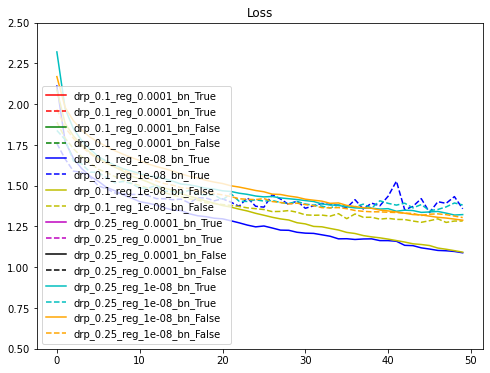

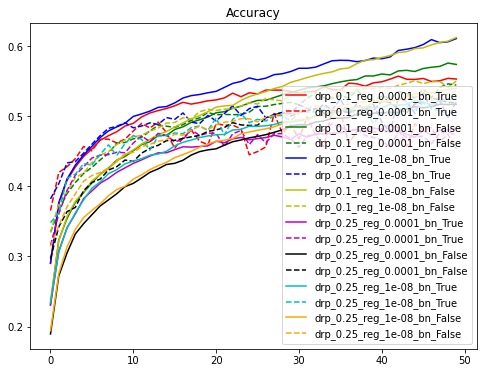

In [9]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results_l1.keys()):
    plt.plot(range(len(results_l1[cond]['train-loss'])),results_l1[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_l1[cond]['valid-loss'])),results_l1[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0.5, 2.5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_l1.keys()):
    plt.plot(range(len(results_l1[cond]['train-acc'])),results_l1[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_l1[cond]['valid-acc'])),results_l1[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## L2

In [15]:
def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], drop_ratio=0.2, l_ratio=0.0001, bn=True):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l_ratio))(input_layer)
            x = Dropout(drop_ratio)(x)
            if bn:
                x = BatchNormalization()(x)
            else:
                pass
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l_ratio))(x)
            x = Dropout(drop_ratio)(x)
            if bn:
                x = BatchNormalization()(x)
            else:
                pass
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
results_l2 = {}

for i in drop_ratio:
    for j in reg_ratio:
        for k in batch_n:
            model = build_mlp_l2(input_shape=x_train.shape[1:], drop_ratio=i, l_ratio=j, bn=k)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)
            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]
            exp_name_tag = f'drp_{str(i)}_reg_{str(j)}_bn_{str(k)}'
            results_l2[exp_name_tag] = {'train-loss': train_loss,
                                        'valid-loss': valid_loss,
                                        'train-acc': train_acc,
                                        'valid-acc': valid_acc}

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024

Epoch 44/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2587 - accuracy: 0.5998 - val_loss: 1.5683 - val_accuracy: 0.4971
Epoch 45/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2489 - accuracy: 0.5979 - val_loss: 1.5254 - val_accuracy: 0.5100
Epoch 46/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2450 - accuracy: 0.5968 - val_loss: 1.5258 - val_accuracy: 0.5122
Epoch 47/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2378 - accuracy: 0.6042 - val_loss: 1.5143 - val_accuracy: 0.5221
Epoch 48/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2403 - accuracy: 0.6019 - val_loss: 1.5782 - val_accuracy: 0.5073
Epoch 49/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2259 - accuracy: 0.6090 - val_loss: 1.5846 - val_accuracy: 0.5001
Epoch 50/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2176 - accuracy: 0.6079 - val_

50000/50000 [==============================] - 2s 41us/step - loss: 1.3358 - accuracy: 0.5739 - val_loss: 1.4529 - val_accuracy: 0.5357
Epoch 40/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.3280 - accuracy: 0.5781 - val_loss: 1.4309 - val_accuracy: 0.5450
Epoch 41/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.3166 - accuracy: 0.5821 - val_loss: 1.4506 - val_accuracy: 0.5337
Epoch 42/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.3131 - accuracy: 0.5793 - val_loss: 1.4426 - val_accuracy: 0.5368
Epoch 43/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.3060 - accuracy: 0.5847 - val_loss: 1.4326 - val_accuracy: 0.5415
Epoch 44/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2968 - accuracy: 0.5891 - val_loss: 1.4425 - val_accuracy: 0.5411
Epoch 45/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2881 - accuracy: 0.5895 - val_loss: 1.4272

Epoch 32/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1915 - accuracy: 0.5723 - val_loss: 1.3893 - val_accuracy: 0.5031
Epoch 33/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1902 - accuracy: 0.5731 - val_loss: 1.3803 - val_accuracy: 0.5074
Epoch 34/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1802 - accuracy: 0.5772 - val_loss: 1.3782 - val_accuracy: 0.5191
Epoch 35/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1776 - accuracy: 0.5782 - val_loss: 1.3796 - val_accuracy: 0.5115
Epoch 36/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1606 - accuracy: 0.5831 - val_loss: 1.3680 - val_accuracy: 0.5125
Epoch 37/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1566 - accuracy: 0.5850 - val_loss: 1.3879 - val_accuracy: 0.5060
Epoch 38/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1531 - accuracy: 0.5851 - val_

50000/50000 [==============================] - 2s 39us/step - loss: 1.3107 - accuracy: 0.5350 - val_loss: 1.3556 - val_accuracy: 0.5168
Epoch 28/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.2988 - accuracy: 0.5379 - val_loss: 1.3439 - val_accuracy: 0.5229
Epoch 29/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.2885 - accuracy: 0.5419 - val_loss: 1.3323 - val_accuracy: 0.5281
Epoch 30/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.2755 - accuracy: 0.5460 - val_loss: 1.3345 - val_accuracy: 0.5253
Epoch 31/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2711 - accuracy: 0.5479 - val_loss: 1.3311 - val_accuracy: 0.5255
Epoch 32/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.2602 - accuracy: 0.5529 - val_loss: 1.3342 - val_accuracy: 0.5308
Epoch 33/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.2515 - accuracy: 0.5545 - val_loss: 1.3151

Epoch 20/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.6214 - accuracy: 0.4663 - val_loss: 1.5667 - val_accuracy: 0.4890
Epoch 21/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.6079 - accuracy: 0.4699 - val_loss: 1.5610 - val_accuracy: 0.4883
Epoch 22/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.6047 - accuracy: 0.4731 - val_loss: 1.5504 - val_accuracy: 0.4895
Epoch 23/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.5896 - accuracy: 0.4784 - val_loss: 1.5395 - val_accuracy: 0.4957
Epoch 24/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5791 - accuracy: 0.4843 - val_loss: 1.5640 - val_accuracy: 0.4908
Epoch 25/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5687 - accuracy: 0.4840 - val_loss: 1.5500 - val_accuracy: 0.4874
Epoch 26/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5638 - accuracy: 0.4884 - val_

50000/50000 [==============================] - 2s 39us/step - loss: 1.7332 - accuracy: 0.4333 - val_loss: 1.6477 - val_accuracy: 0.4656
Epoch 16/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.7211 - accuracy: 0.4378 - val_loss: 1.6298 - val_accuracy: 0.4712
Epoch 17/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.7080 - accuracy: 0.4393 - val_loss: 1.6229 - val_accuracy: 0.4721
Epoch 18/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.6941 - accuracy: 0.4454 - val_loss: 1.6092 - val_accuracy: 0.4766
Epoch 19/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6804 - accuracy: 0.4530 - val_loss: 1.6110 - val_accuracy: 0.4803
Epoch 20/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6690 - accuracy: 0.4539 - val_loss: 1.5984 - val_accuracy: 0.4823
Epoch 21/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6538 - accuracy: 0.4609 - val_loss: 1.5958

Epoch 8/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.6278 - accuracy: 0.4155 - val_loss: 1.5181 - val_accuracy: 0.4532
Epoch 9/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5978 - accuracy: 0.4276 - val_loss: 1.5037 - val_accuracy: 0.4589
Epoch 10/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5830 - accuracy: 0.4313 - val_loss: 1.4950 - val_accuracy: 0.4639
Epoch 11/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.5738 - accuracy: 0.4372 - val_loss: 1.4884 - val_accuracy: 0.4662
Epoch 12/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5708 - accuracy: 0.4350 - val_loss: 1.4771 - val_accuracy: 0.4739
Epoch 13/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5501 - accuracy: 0.4436 - val_loss: 1.4611 - val_accuracy: 0.4750
Epoch 14/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5313 - accuracy: 0.4499 - val_lo

50000/50000 [==============================] - 2s 41us/step - loss: 1.9111 - accuracy: 0.3081 - val_loss: 1.7998 - val_accuracy: 0.3692
Epoch 4/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.8549 - accuracy: 0.3326 - val_loss: 1.7593 - val_accuracy: 0.3824
Epoch 5/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.8123 - accuracy: 0.3491 - val_loss: 1.7088 - val_accuracy: 0.3973
Epoch 6/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.7793 - accuracy: 0.3637 - val_loss: 1.6735 - val_accuracy: 0.4125
Epoch 7/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7473 - accuracy: 0.3761 - val_loss: 1.6461 - val_accuracy: 0.4189
Epoch 8/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7216 - accuracy: 0.3846 - val_loss: 1.6230 - val_accuracy: 0.4292
Epoch 9/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7014 - accuracy: 0.3927 - val_loss: 1.6073 - val

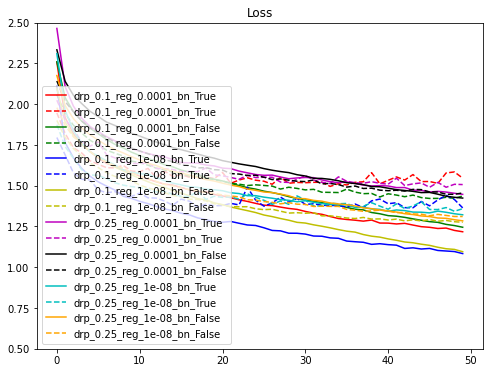

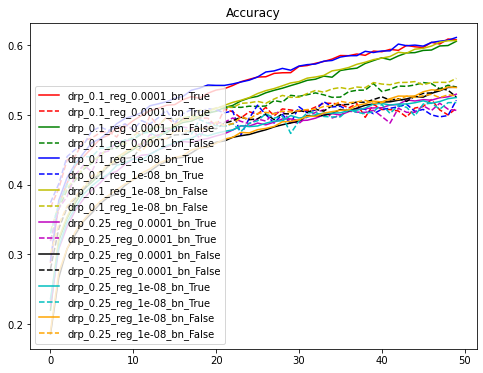

In [19]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results_l2.keys()):
    plt.plot(range(len(results_l2[cond]['train-loss'])),results_l2[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_l2[cond]['valid-loss'])),results_l2[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0.5, 2.5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_l2.keys()):
    plt.plot(range(len(results_l2[cond]['train-acc'])),results_l2[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_l2[cond]['valid-acc'])),results_l2[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc=3)
plt.show()